# Linear Frequency Modulated (LFM) Impulses Part 3: Finite Duration Rising and Falling Times, Phase or Frequency Predistortion

[![nbviewer](https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg)](https://nbviewer.org/github/olddudealex/rf-notebooks/blob/main/pulse-modulation_pt3.ipynb) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/olddudealex/rf-notebooks/blob/main/pulse-modulation_pt3.ipynb) [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/olddudealex/rf-notebooks/HEAD?labpath=pulse-modulation_pt3.ipynb)

In previous parts we've looked at the Linear Chirp with and without Hamming weighting and pulse compression applied to such impulses. Now we will focus on very specific technique, that can be used for decreasing side lobes - **frequency predistortion**.

The idea of this method is to add linear FM distortion segments (quadratic phase modulation distortion) in the beginning and end of the LFM pulse. According to the wiki this method is effective because amplitude and phase distortions having functional similarity can produce similar effects when the distortion factors are small. In other words it's an alternative to amplitude weighting, particularly the variant of amplitude weigting by slow fade in/out start and end. Let's look at such limited rise/fall times signal first and then see how the frequency predistorted impulse works.

## Introducing Rise and Fall Times of Finite Duration

Let's see the results of pulse compression for the LFM impulse with slowed down fade in/out.

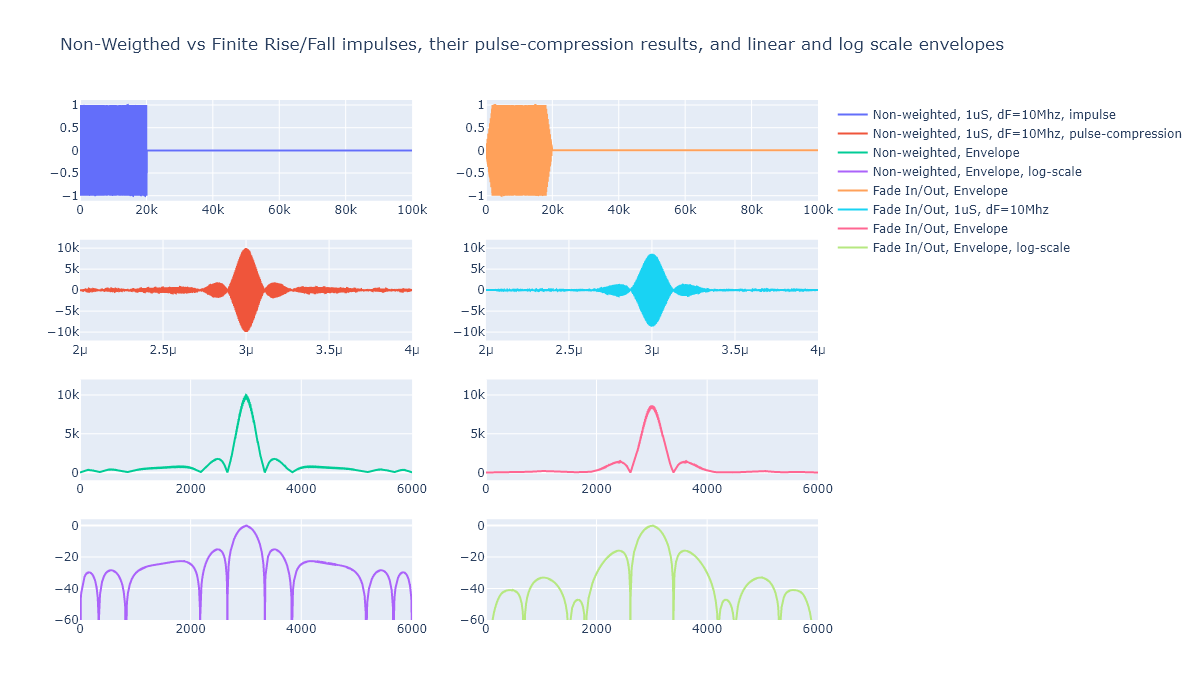

In [1]:
import plotly.io as pio

# The next line is a special one for auto-generation of static page version.
static_rendering = True
if static_rendering:
  pio.renderers.default = "png"
  import sys
  import os
  parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
  sys.path.insert(0, parent_dir)
elif 'google.colab' in str(get_ipython()):
  %cd /content
  !rm -rf rf-notebooks
  !git clone -q -s https://github.com/olddudealex/rf-notebooks/ rf-notebooks
  %cd rf-notebooks
  pio.renderers.default = "colab"
  print("The colab renderer is used")
else:
  pio.renderers.default = "plotly_mimetype+notebook"
  print("The notebook renderer is used")

import plot_data as pd
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Initial parameters, common for all the signals on this page
sim_dur = 5000*(10**(-9))
tu = 5*(10**(-11))
f0 = 3*(10**9)             # center freq
delta_f = 10*(10**6)       # freq span

# Fade In/Out signal
s_fade = pd.LfmSignal(f0=3*(10**9), delta_f=delta_f, tu=tu,
                      l_sec=1000*(10**(-9)), s_sec=0, sim_dur=5000*(10**(-9)))

# creating the window
dt_fade = s_fade.L//10
k_fade = 1 / dt_fade
window = np.ones(s_fade.L)
for i in range(0, dt_fade):
  val = i * k_fade
  window[i] = val
  window[-i] = val

# finalize the signal
s_fade.sig.data[:s_fade.L] = window * s_fade.sig.data[:s_fade.L]
data_fade = pd.PlotData(s_fade.sig.data, s_fade.sig.fs)
data_fade.trim_freq(s_fade.f0 - 2*s_fade.delta_f, s_fade.f0 + 2*s_fade.delta_f)

reflected_signal_fade = np.roll(s_fade.sig.data, s_fade.L * 2)
pulse_compression_fade = np.convolve(s_fade.sig.data, np.flip(reflected_signal_fade))

# Create the ordinary LFM signal for comparison
s_lfm = pd.LfmSignal(f0=3*(10**9), delta_f=delta_f, tu=tu,
                  l_sec=1000*(10**(-9)), s_sec=0, sim_dur=5000*(10**(-9)))
data_lfm = pd.PlotData(s_lfm.sig.data, s_lfm.sig.fs)
data_lfm.trim_freq(s_lfm.f0 - 2*s_lfm.delta_f, s_lfm.f0 + 2*s_lfm.delta_f)
reflected_signal_lfm = np.roll(s_lfm.sig.data, s_lfm.L * 2)
pulse_compression_lfm = np.convolve(s_lfm.sig.data, np.flip(reflected_signal_lfm))

start = int(2*(10**(-6))/s_fade.sig.tu)
end = int(4*(10**(-6))/s_fade.sig.tu)

# idea of it is from https://stackoverflow.com/questions/34235530/how-to-get-high-and-low-envelope-of-a-signal
def get_envelope(s):
    max_ind = (np.diff(np.sign(np.diff(s))) < 0).nonzero()[0] + 1
    max_env = [s[i] for i in max_ind]
    return max_ind, max_env

fig = make_subplots(rows=4, cols=2)
fig.add_trace(go.Scatter(y=data_lfm.time_domain,
                         name=f"Non-weighted, 1uS, dF=10Mhz, impulse"), row=1, col=1)
fig.add_trace(go.Scatter(x=np.linspace(0, sim_dur, s_lfm.sig.data.size)[start:end],
                         y=pulse_compression_lfm[start:end],
                         name=f"Non-weighted, 1uS, dF=10Mhz, pulse-compression"), row=2, col=1)
pc_envelope_lfm = get_envelope(pulse_compression_lfm[start:end])[1]
pc_envelope_lfm = [x if x > 0 else 0.000001 for x in pc_envelope_lfm]
fig.add_trace(go.Scatter(y=pc_envelope_lfm,
                         name=f"Non-weighted, Envelope"), row=3, col=1)
fig.add_trace(go.Scatter(y=20*np.log10(pc_envelope_lfm/np.max(pc_envelope_lfm)),
                         name=f"Non-weighted, Envelope, log-scale"), row=4, col=1)

fig.add_trace(go.Scatter(y=data_fade.time_domain,
                         name=f"Fade In/Out, Envelope"), row=1, col=2)
fig.add_trace(go.Scatter(x=np.linspace(0, sim_dur, s_fade.sig.data.size)[start:end],
                         y=pulse_compression_fade[start:end],
                         name=f"Fade In/Out, 1uS, dF=10Mhz"), row=2, col=2)
pc_envelope_pretrig = get_envelope(pulse_compression_fade[start:end])[1]
pc_envelope_pretrig = [x if x > 0 else 0.000001 for x in pc_envelope_pretrig]
fig.add_trace(go.Scatter(y=pc_envelope_pretrig,
                         name=f"Fade In/Out, Envelope"), row=3, col=2)
fig.add_trace(go.Scatter(y=20*np.log10(pc_envelope_pretrig/np.max(pc_envelope_pretrig)),
                         name=f"Fade In/Out, Envelope, log-scale"), row=4, col=2)

fig.update_layout(hovermode='x unified', height=700,
                  width=1200, title_text="Non-Weigthed vs Finite Rise/Fall impulses, their pulse-compression results, and linear and log scale envelopes")
fig.update_yaxes(range = [-12000, 12000], row=2)
fig.update_yaxes(range = [-1000, 12000], row=3)
fig.update_yaxes(range = [-60, 4], row=4)
fig.update_xaxes(exponentformat="SI")
fig.show()

The results are quite modest - there is significant reduction of secondary range sidelobes, but the main sidelobes almost didn't change. And at the same time we lost some absolute amplitude (sensitivity) and the main lobe now is wider - the range precision is reduced.
I think there is a potential in this method, and I encourage the reader to try to improve the profile to get better results.



## Phase (Frequency) Predistortion

Now we can try the frequency or phase predistortion, because from the basic concepts of distortion theory, it is known that amplitude and phase distortions having functional similarity can produce similar effects on the time waveform when the distortion factors are small [[2]](#2).

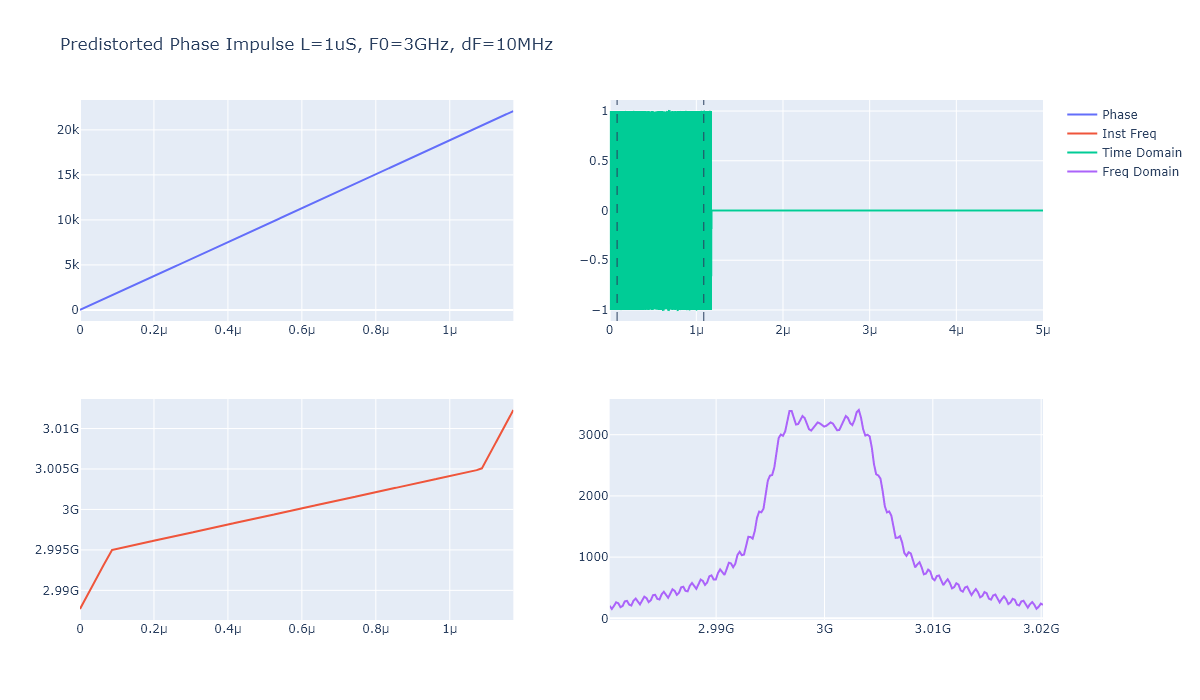

In [2]:
# Predistorted signal params
predist_delta_f = 0.73*delta_f
predist_delta_t = 0.86/delta_f

sig = pd.Signal(tu, sim_dur)

f2 = f0 - delta_f / 2
f3 = f0 + delta_f / 2
f1 = f2 - predist_delta_f
f4 = f3 + predist_delta_f

L_sec = 10**(-6)        # length of impulse
s1_sec = 0                  
s2_sec = predist_delta_t
s3_sec = s2_sec + L_sec
s4_sec = s3_sec + predist_delta_t        

# convert time seconds to array indexes
s1 = int(s1_sec / sig.tu)
s2 = int(s2_sec / sig.tu)
s3 = int(s3_sec / sig.tu)
s4 = int(s4_sec / sig.tu)

# create the freq modulated impulse
sig.data = np.zeros(sig.t.shape)
sig.data = np.zeros(sig.t.shape)

k1 = predist_delta_f / (s2_sec-s1_sec)
k2 = delta_f / (s3_sec-s2_sec)
k3 = k1

# Segment durations
t1 = sig.t[s1:s2] - sig.t[s1]
t2 = sig.t[s2:s3] - sig.t[s2]
t3 = sig.t[s3:s4] - sig.t[s3]

phase1 = 2 * np.pi * (f1 + k1 * t1 / 2) * t1
freq1 = np.diff(phase1, n=1) / (2*np.pi*sig.tu)

phase2_raw = 2 * np.pi * (freq1[-1] + k2 * t2 / 2) * t2
freq2 = np.diff(phase2_raw, n=1) / (2*np.pi*sig.tu)
phase_step_12 = phase2_raw[0]- phase1[-1]
phase2 = phase2_raw - phase_step_12 + freq1[-1]*2*np.pi*sig.tu

phase3_raw = 2 * np.pi * (freq2[-1] + k3 * t3 / 2) * t3
phase_step_23 = phase3_raw[0] - phase2[-1]
phase3 = phase3_raw - phase_step_23 + freq2[-1]*2*np.pi*sig.tu

phase = np.concatenate([phase1, phase2, phase3])
freq = np.diff(phase, n=1) / (2*np.pi*sig.tu)

# calculate the signals
sig.data[s1:s4] = np.cos(phase)

data = pd.PlotData(sig.data, sig.fs)
data.trim_freq(f0 - 2*delta_f, f0 + 2*delta_f)

fig = make_subplots(rows=2, cols=2)
fig.add_trace(go.Scatter(x=data.time_domain_x,
                         y=phase,
                         name=f"Phase"), row=1, col=1)
fig.add_trace(go.Scatter(x=data.time_domain_x,
                         y=freq,
                         name=f"Inst Freq"), row=2, col=1)
fig.add_trace(go.Scatter(x=data.time_domain_x,
                         y=data.time_domain,
                         name=f"Time Domain"), row=1, col=2)
fig.add_trace(go.Scatter(x=data.freq_domain_x,
                         y=data.freq_domain,
                         name=f"Freq Domain"), row=2, col=2)

fig.add_vline(x=s2_sec, line_width=1, line_dash="dash", row=1, col=2)
fig.add_vline(x=s3_sec, line_width=1, line_dash="dash", row=1, col=2)
fig.update_layout(hovermode='x unified', height=700, width=1200, title_text="Predistorted Phase Impulse L=1uS, F0=3GHz, dF=10MHz")
fig.update_xaxes(exponentformat="SI")
fig.update_yaxes(exponentformat="SI")
fig.show()

Above you can easily see the predistortion on frequency graph (red one). But unforturnately it's not visible on phase graph (blue) due to the scale. You could check that the phase is continious on time domain graph (green), I added the vertical lines on these timestamps.  

Let's compare now the spectrum for ordinary LFM and predistorted LFM impulses:

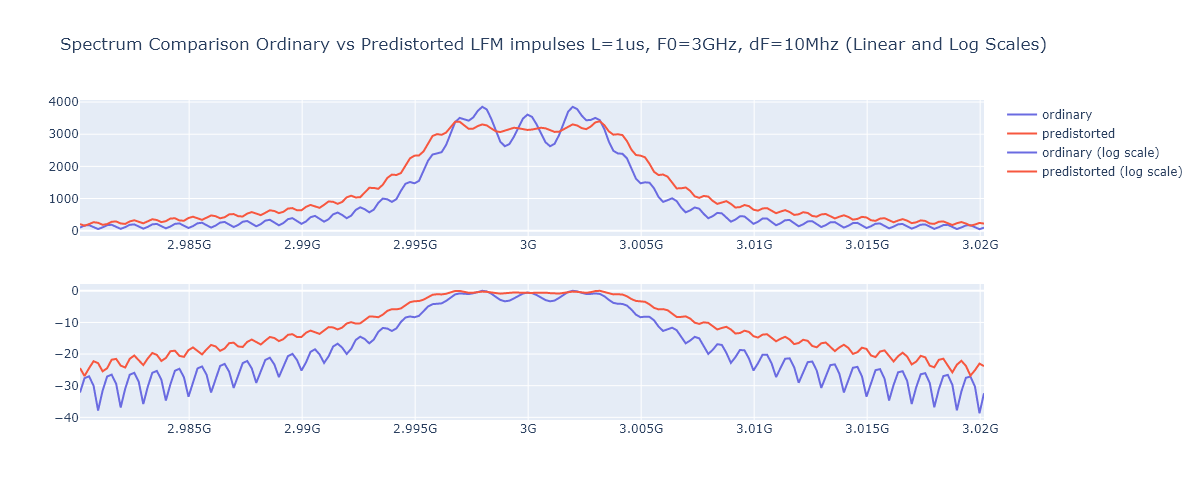

In [3]:
def log_scale(data: pd.PlotData):
    ref = data.freq_domain[data.freq_peaks[0]]
    return 20 * np.log10(data.freq_domain / ref)

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=data_lfm.freq_domain_x,
                         y=data_lfm.freq_domain,
                         name="ordinary",
                         line_color="#6A6BE1"), row=1, col=1)
fig.add_trace(go.Scatter(x=data.freq_domain_x,
                         y=data.freq_domain,
                         name="predistorted",
                         line_color="#F7573F"), row=1, col=1)
fig.add_trace(go.Scatter(x=data_lfm.freq_domain_x,
                         y=log_scale(data_lfm),
                         name="ordinary (log scale)",
                         line_color="#6A6BE1"), row=2, col=1)
fig.add_trace(go.Scatter(x=data.freq_domain_x,
                         y=log_scale(data),
                         name="predistorted (log scale)",
                         line_color="#F7573F"), row=2, col=1)

fig.update_layout(hovermode='x unified', height=500, 
                  width=1200, title_text="Spectrum Comparison Ordinary vs Predistorted LFM impulses L=1us, F0=3GHz, dF=10Mhz (Linear and Log Scales)")
fig.update_xaxes(exponentformat="SI")
fig.show()

The frequency band is increased, which is bad, but expected. Also important, that the phase predistortion decreases the spectrum ripples, it should decrease the range sidelobes. Let's check.

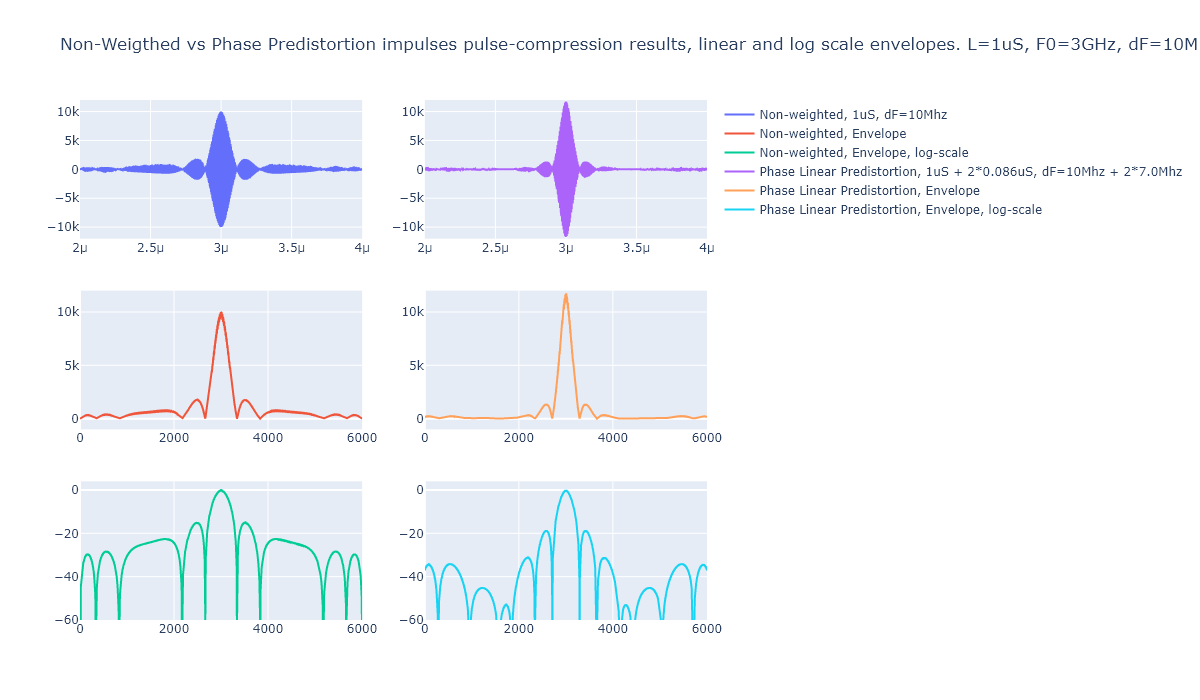

In [4]:
s_ind_predist = sig
reflected_signal_predist = np.roll(sig.data, s_lfm.L * 2)
pulse_compression_predist = np.convolve(s_ind_predist.data, np.flip(reflected_signal_predist))

fig = make_subplots(rows=3, cols=2)
fig.add_trace(go.Scatter(x=np.linspace(0, sim_dur, s_lfm.sig.data.size)[start:end],
                         y=pulse_compression_lfm[start:end],
                         name=f"Non-weighted, 1uS, dF=10Mhz"), row=1, col=1)
fig.add_trace(go.Scatter(y=pc_envelope_lfm,
                         name=f"Non-weighted, Envelope"), row=2, col=1)
fig.add_trace(go.Scatter(y=20*np.log10(pc_envelope_lfm/np.max(pc_envelope_lfm)),
                         name=f"Non-weighted, Envelope, log-scale"), row=3, col=1)

fig.add_trace(go.Scatter(x=np.linspace(0, sim_dur, s_ind_predist.data.size)[start:end],
                         y=pulse_compression_predist[start:end],
                         name=f"Phase Linear Predistortion, 1uS + 2*{predist_delta_t*10**6:.3f}uS, dF=10Mhz + 2*{predist_delta_f//(10**6)}Mhz"), row=1, col=2)
pc_envelope_pretrig = get_envelope(pulse_compression_predist[start:end])[1]
pc_envelope_pretrig = [x if x > 0 else 0.000001 for x in pc_envelope_pretrig]
fig.add_trace(go.Scatter(y=pc_envelope_pretrig,
                         name=f"Phase Linear Predistortion, Envelope"), row=2, col=2)
fig.add_trace(go.Scatter(y=20*np.log10(pc_envelope_pretrig/np.max(pc_envelope_pretrig)),
                         name=f"Phase Linear Predistortion, Envelope, log-scale"), row=3, col=2)

fig.update_layout(hovermode='x unified', height=700,
                  width=1200, title_text="Non-Weigthed vs Phase Predistortion impulses pulse-compression results, linear and log scale envelopes. L=1uS, F0=3GHz, dF=10Mhz")
fig.update_yaxes(range = [-12000, 12000], row=1)
fig.update_yaxes(range = [-1000, 12000], row=2)
fig.update_yaxes(range = [-60, 4], row=3)
fig.update_xaxes(exponentformat="SI")
fig.show()

In our example the predistortion of impulse helped to decrease the main side lobes from -14.9dB to -18.6dB (almost 3dB better). The effect on the secondary side lobes is even more explicit, theoretically it could be helpfull for detecting really small amplitude targets.

The amplitude of compressed pulse is higher for modified pulse, but it's just a side effect of increasing it's time. Generally, we can adjust the parameters to keep the original impulse length, than the compressed impulse amplitude should be close to the original one.

The main disadvantage of this method is slight increase of required frequency band.

## References

<a id="1">[1]</a>
Chirp spectrum. (2024, November 11). In *Wikipedia*. Retrieved November 11, 2024, from https://en.wikipedia.org/wiki/Chirp_spectrum  
<a id="2">[2]</a>
Cook C.E. & Paolillo J., "A Pulse Compression Predistortion Function for Efficient Sidelobe Reduction in a High-Power Radar", Proc. IEEE Vol.52, April 1964 (pp.377-384)